## Target and Numerical columns

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dbpedia_common import DataFrameRepository, display_side_by_side, print_df
from models import CalculatedPopTransformer, CategoricalThresholdTransformer

train_out_df = DataFrameRepository(version='v1-outliers').get() # original df with errors
train_df = DataFrameRepository(version='last').get() # Fixed df after outliers were fixed

from scipy import stats

In [3]:
print(f'shape: {train_df.shape}')
train_df.head()

shape: (39630, 60)


,subject,target,<http://dbpedia.org/ontology/areaLand>,<http://dbpedia.org/ontology/areaTotal>,<http://dbpedia.org/ontology/areaWater>,<http://dbpedia.org/ontology/elevation>,<http://dbpedia.org/ontology/populationDensity>,areaLand>NAN,areaTotal>NAN,areaWater>NAN,elevation>NAN,populationDensity>NAN,areaCode#count,areaLand#count,areaTotal#count,areaWater#count,birthPlace?inv#count,city?inv#count,country#count,countySeat?inv#count,deathPlace?inv#count,district#count,elevation#count,foundingDate#count,governmentType#count,gridReference#count,ground?inv#count,headquarter?inv#count,hometown?inv#count,largestCity?inv#count,licenceNumber#count,location?inv#count,motto#count,nearestCity?inv#count,originalName#count,politicalLeader#count,populationAsOf#count,populationDensity#count,postalCode#count,residence?inv#count,restingPlace?inv#count,routeEnd?inv#count,routeJunction?inv#count,routeStart?inv#count,subdivision#count,subdivision?inv#count,timeZone#count,type#count,utcOffset#count,22-rdf-syntax-ns#type#count,rdf-schema#seeAlso#count,homepage#count,name#count,nick#count,rare_rel#count,total_rel#count,unique_rel#count,place_type#cat,utc_offset#cat,country#cat
0,<http://dbpedia.org/resource/'Amran>,290792.000,0.000,0.000,0.000,0.000,0.000,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,9,0,0,1,0,2,30,10,City,3,Yemen
1,"<http://dbpedia.org/resource/'t_Zand,_Schagen>",2320.000,0.000,0.000,0.000,0.000,0.000,1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,8,0,0,1,0,1,34,14,Town,"1,2",Netherlands
2,<http://dbpedia.org/resource/100_Mile_House>,1980.000,0.000,53290000.000,0.000,927.000,35.400,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,3,0,1,0,0,0,0,0,0,3,0,1,1,1,8,0,1,2,0,3,54,30,Town,-8,NAN
3,<http://dbpedia.org/resource/13th_district_of_...,120256.000,0.000,13430000.000,0.000,0.000,8954.000,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,1,2,0,0,0,0,0,4,1,2,1,3,8,0,1,3,0,4,64,30,Region,"1,2",Hungary
4,<http://dbpedia.org/resource/16th_district_of_...,73486.000,0.000,33510000.000,0.000,0.000,2192.000,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2,1,0,1,2,0,0,0,0,0,2,1,2,1,3,8,0,1,3,0,4,64,34,Region,"1,2",Hungary


#### Here we can see how the errors in dbpedia files can affect our predictions. In this case, Lages has the wrong population value not only in dbpedia but also in wikipedia! I had to do a lot of research to be sure

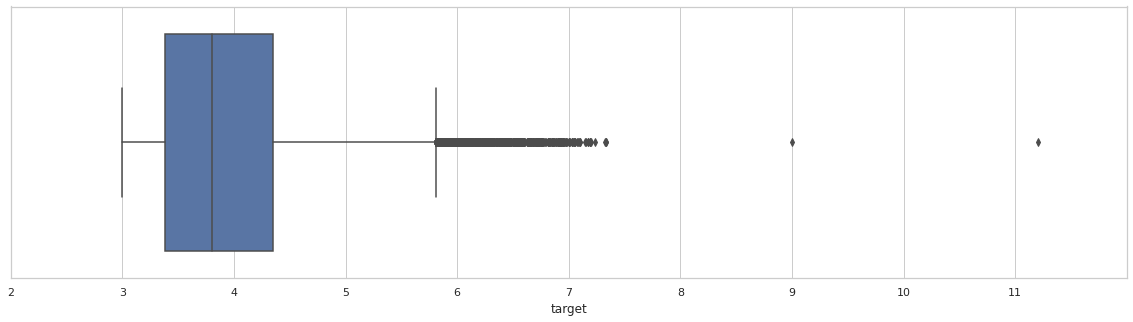

In [7]:
def plot_boxplot(target):
    plt.figure(figsize=(20,5))
    ax = sns.boxplot(x=np.log10(target))
    ax.set_xlim(2,12)
    ax.set_xticks(range(2,12))
    describe_df = target.describe().to_frame()
    describe_df['log10 target'] = np.log10(target).describe()
    print_df(describe_df.transpose())

plot_boxplot(train_out_df.target)

In [162]:
possible_error = train_out_df.loc[train_out_df.target.idxmax()]
print(f'Name: {possible_error.subject}, population: {possible_error.target}')

Name: <http://dbpedia.org/resource/Lages>, population: 158846975337.0


* Real population is: 157,544. Sources:

* https://www.ibge.gov.br/cidades-e-estados/sc/lages.html
* https://www.mindat.org/loc-30627.html
* https://www.citypopulation.de/en/brazil/cities/santacatarina/
* https://en.wikipedia.org/wiki/Lages Population in wikipedia page is wrong. It's like population was concatenated with some other number. This number is even bigger than Brazil's population!

In [163]:
lages_id = train_out_df.target.idxmax()
possible_error = train_out_df.loc[train_out_df.drop(lages_id).target.idxmax()]
print(f'Name: {possible_error.subject}, population: {possible_error.target}')

Name: <http://dbpedia.org/resource/Sarangpur,_Madhya_Pradesh>, population: 1000000000.0


* Real population is: 37,435
* https://en.wikipedia.org/wiki/Sarangpur,_Madhya_Pradesh

### Now we are going to use a dataframe that was fixed in preprocessing.ipynb
* It's very similar to a Chi square disribution

In [4]:
print_df(train_df.target.describe().to_frame().transpose())
print_df(np.log10(train_df.target).describe().to_frame().transpose())

,count,mean,std,min,25%,50%,75%,max
target,39630.000,74486.082,530840.385,1000.000,2402.000,6377.000,22397.500,24281400.000


,count,mean,std,min,25%,50%,75%,max
target,39630.000,3.940,0.700,3.000,3.381,3.805,4.350,7.385


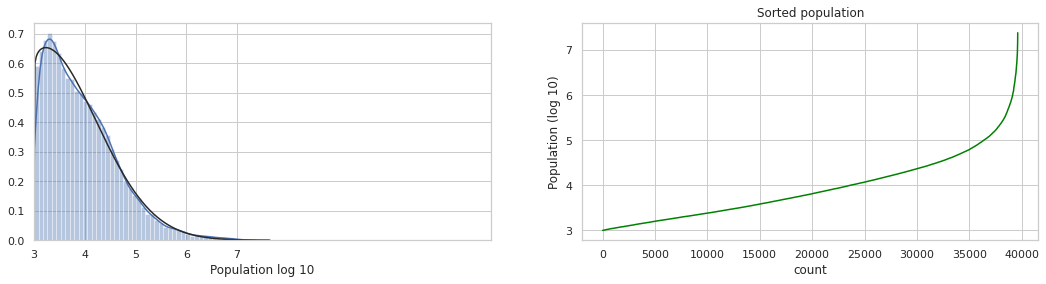

In [11]:
def plot_target(target):
    fig, ax = plt.subplots(1, 2, figsize=(18,4))
    sns.distplot(target, kde=True, ax=ax[0], axlabel='Population log 10', fit=stats.chi)
    max_limit = int(target.max()) + 1
    ax[0].set_xlim(3,12)
    ax[0].set_xticks(range(3,max_limit))

    ax[1].plot(sorted(target), label='log 10 target population', color='green')
    plt.ylabel('Population (log 10)')
    plt.xlabel('count')
    plt.title('Sorted population')
    plt.grid(True)   
plot_target(np.log10(train_df.target))

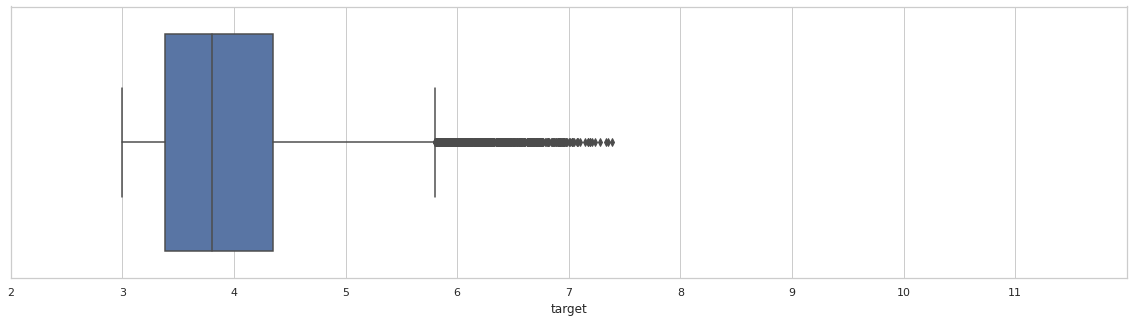

In [8]:
plot_boxplot(train_df.target)

In [17]:
numeric_columns = [
    '<http://dbpedia.org/ontology/areaLand>',
    '<http://dbpedia.org/ontology/areaTotal>',
    '<http://dbpedia.org/ontology/areaWater>',
    '<http://dbpedia.org/ontology/elevation>',
    '<http://dbpedia.org/ontology/populationDensity>',
]
train_df.loc[train_df['<http://dbpedia.org/ontology/elevation>'] < 0, '<http://dbpedia.org/ontology/elevation>'] = 0
counter_columns = ['unique_rel#count', 'total_rel#count', 'rare_rel#count']

df = train_df.copy()
df['log_target'] = np.log10(train_df.target)

* #### The columns _total_rel#counts_ and _rare_rel#counts_ have a very big outlier (London). We will have to transform the features too. It's the same with other features like Area
* ####  There is a very weak correlation between the target and them, but if we remove zeroes (which are Null values actually in this case), we can see it improves significatively
* #### areaTotal has a good correlation, but it's only 2/3 of the time. 

In [24]:
df_log = df[['target'] + numeric_columns + counter_columns].copy()
df_log = df_log.replace(0, np.nan)
df_log = np.log1p(df_log)
new_df = pd.DataFrame(df_log.corr()[['target']]).sort_values('target', ascending=False)
new_df['% of Non Null'] = df_log.notnull().mean() * 100
print_df(new_df)

,target,% of Non Null
target,1.000,100.000
<http://dbpedia.org/ontology/areaTotal>,0.627,67.434
<http://dbpedia.org/ontology/areaLand>,0.568,31.552
total_rel#count,0.438,100.000
rare_rel#count,0.392,100.000
<http://dbpedia.org/ontology/populationDensity>,0.350,28.668
<http://dbpedia.org/ontology/areaWater>,0.335,19.864
unique_rel#count,0.261,100.000
<http://dbpedia.org/ontology/elevation>,-0.059,59.326


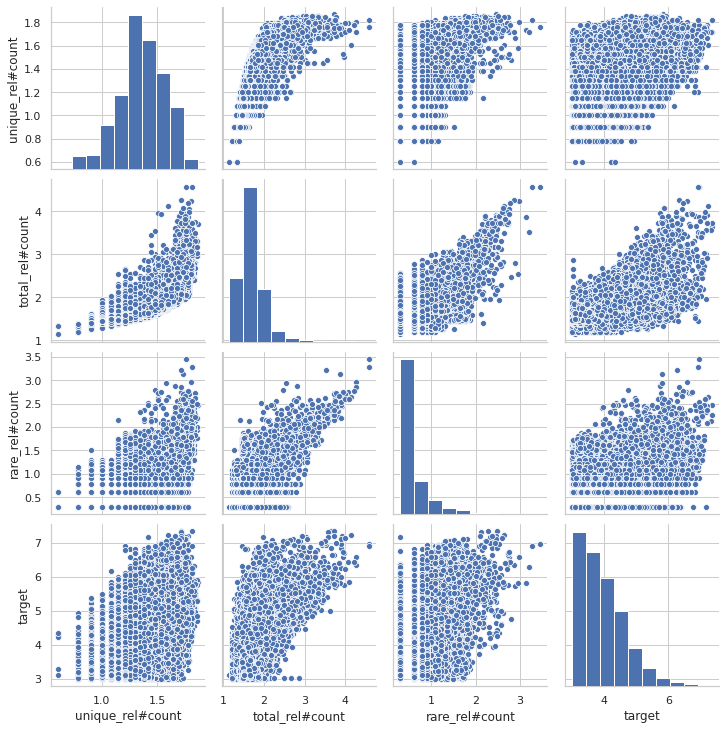

In [170]:
df_log = pd.concat([np.log10(df[counter_columns + ['target']])], axis=1)
sns.pairplot(df_log)

In [11]:
print(f'percentage of Non 0\'s. (For non-count features, 0 means NaN)')
df = (train_df != 0).sum().div(len(train_df) * 0.01).sort_values(ascending=False).to_frame()
df.columns = ['% non zero']       
display_side_by_side(df[:29], df[29:])


percentage of Non 0's. (For non-count features, 0 means NaN)


,% non zero
target,100.00000
rare_rel#count,100.00000
unique_rel#count,100.00000
total_rel#count,100.00000
22-rdf-syntax-ns#type#count,100.00000
subject,100.00000
name#count,91.08981
country#count,76.71796
subdivision#count,73.50151
<http://dbpedia.org/ontology/areaTotal>,67.25782


## Target split in bins from _too small_ to XL:

* 3: Too small (1000 - 10000)
* 4: Small (10000 - 100000)
* 5: Medium (100000 - 1000000)
* 6: Large (+1,000,000)
* 7: XL (+10,000,000)


/home/fernando/anaconda3/envs/art_feat_eng_book/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log1p
  """Entry point for launching an IPython kernel.
/home/fernando/anaconda3/envs/art_feat_eng_book/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


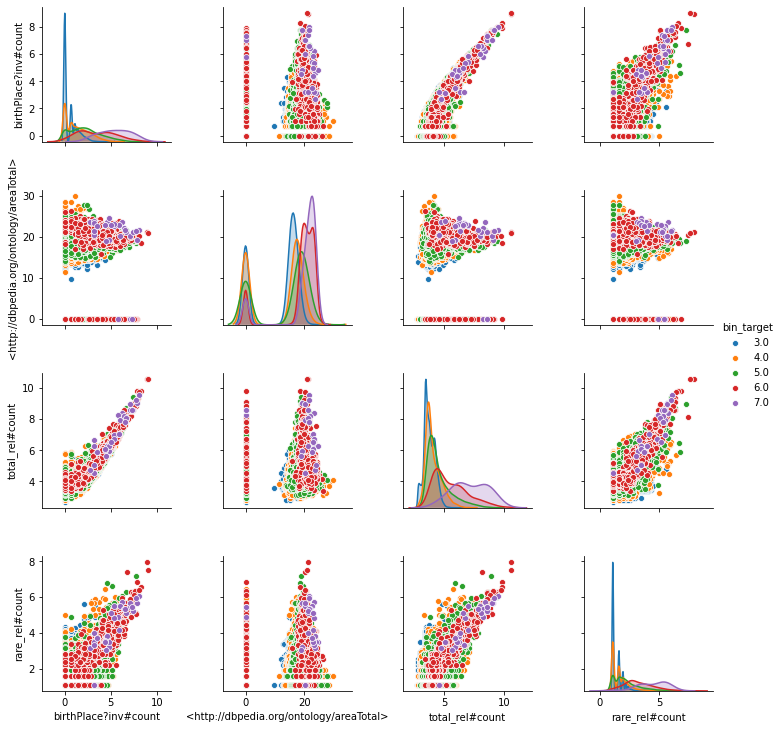

In [12]:
df = np.log1p(train_df.drop(columns=['subject'])).copy()
df['bin_target'] = np.floor(np.array(np.log10(train_df['target'])))
columns = ['birthPlace?inv#count', '<http://dbpedia.org/ontology/areaTotal>', 'total_rel#count', 
           'rare_rel#count', 'bin_target']
sns.pairplot(df[columns], hue="bin_target");


### Feature: calc_population
 * #### When both area and populationDensity are available, we calculate the expected population: (squared_area * density / 1_000_000).
 * #### The problem is that sometimes the area column is wrong (Woodstock,_Ontario) and other times is populationDensity the one with errors (Paintsville,_Kentucky). Besides, Area and populationDensity appear together just a 25% of the time


* Woodstock,_Ontario: Area should be: 48575,99 instead of 48575990000
* Paintsville,_Kentucky: populationDensity should be: 876 instead of 876264
* Niles,_Illinois: populationDensity should be 108.68 instead of 1976

In [40]:
# some examples of bad data
df = DataFrameRepository(version='last').get()
df = CalculatedPopTransformer().fit_transform(df)[['subject', 'calc_population', 'target', '<http://dbpedia.org/ontology/areaLand>', '<http://dbpedia.org/ontology/populationDensity>']]
df.loc[(df['calc_population'] > 0), 'diff'] = df['calc_population'] - df['target']
df.loc[(df['calc_population'] > 0)].sort_values('diff', ascending=False).head()

,subject,calc_population,target,<http://dbpedia.org/ontology/areaLand>,<http://dbpedia.org/ontology/populationDensity>,diff
38402,"<http://dbpedia.org/resource/Woodstock,_Ontario>",40575524.447,40902.000,48575990000.000,835.300,40534622.447
25951,"<http://dbpedia.org/resource/Paintsville,_Kent...",3790087.280,3459.000,4325280.144,876264.000,3786628.280
17160,"<http://dbpedia.org/resource/Kenner,_Louisiana>",1161747.643,66702.000,39108820.466,29705.515,1095045.643
18018,<http://dbpedia.org/resource/Kowloon>,2883211.000,2108419.000,67000000.000,43033.000,774792.000
11345,<http://dbpedia.org/resource/Fort_Bragg>,384587.280,39457.000,646800000.000,594.600,345130.280


# Categorical data

In [45]:
cat_df = DataFrameRepository(version='last').get()[['target', 'place_type#cat', 'country#cat', 'utc_offset#cat']].copy()
cat_df = CategoricalThresholdTransformer('country#cat', threshold=0.97).fit_transform(cat_df)
cat_df = CategoricalThresholdTransformer('utc_offset#cat', threshold=0.95).fit_transform(cat_df)
cat_df['log_target'] = np.log10(cat_df['target'])

Selecting 96 country#cat of 244 to get 97.0% of the data
Renaming the rest of the country#cat values to OTHER
Selecting 19 utc_offset#cat of 87 to get 95.0% of the data
Renaming the rest of the utc_offset#cat values to OTHER


## Countries

In [46]:
countries_count_df = cat_df['country#cat'].value_counts().rename('Count').to_frame()
countries_count_df.index.name = 'Country'
fraction = int(len(countries_count_df) / 5)
display_side_by_side(countries_count_df[:fraction], countries_count_df[fraction:fraction*2],
                     countries_count_df[fraction*2:fraction*3], countries_count_df[fraction*3:fraction*4],
                    countries_count_df[fraction*4:])

,Count
Country,
NAN,9271
Germany,3569
United_States,3469
Australia,2555
United_Kingdom,2370
India,1941
Poland,1708
OTHER,1203
Czech_Republic,880


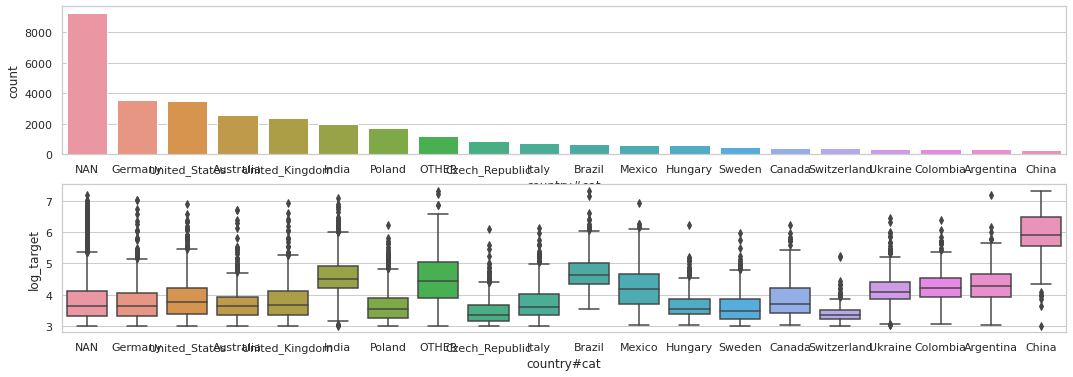

In [354]:
limit = 20
top_countries = cat_df[cat_df['country#cat'].isin(countries_count_df.index[:limit])].copy()

fig, ax = plt.subplots(2, 1, figsize=(18,6))
sns.countplot(data = top_countries, x = 'country#cat', ax = ax[0], order = countries_count_df.index[:limit])
sns.boxplot(data = top_countries, x='country#cat', y='log_target' , ax = ax[1], order = countries_count_df.index[:limit])

## Place type

In [47]:
place_counts_df = cat_df['place_type#cat'].value_counts().rename('Count').sort_values(ascending=False).to_frame()
place_counts_df.transpose()

,NAN,Town,City,Village,Region,Island,Country
Count,17134,9345,9158,2960,1017,15,1


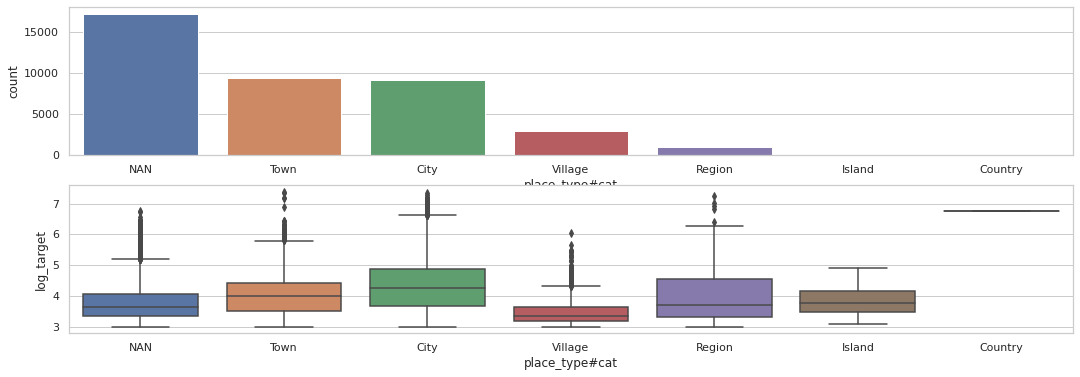

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(18,6))
sns.countplot(data = cat_df, x = 'place_type#cat', ax = ax[0], order=place_counts_df.index)
sns.boxplot(data = cat_df, x='place_type#cat', y='log_target' , ax = ax[1], order=place_counts_df.index)

## UTC OFFSET

In [355]:
utc_offset_count_df = cat_df['utc_offset#cat'].value_counts().rename('Count').to_frame()
utc_offset_count_df.index.name = 'utc_offset'
utc_offset_count_df.transpose()

utc_offset,NAN,"-4,-5","-5,-6","1,2",OTHER,5:30,"-7,-8",-5,"2,3","-6,-7",8,1,"-2,-3",2,-3,3,9,"3:30,4:30",-7,0
Count,14781,5886,4169,3327,2088,2020,1361,883,852,705,523,487,419,413,396,352,318,265,203,192


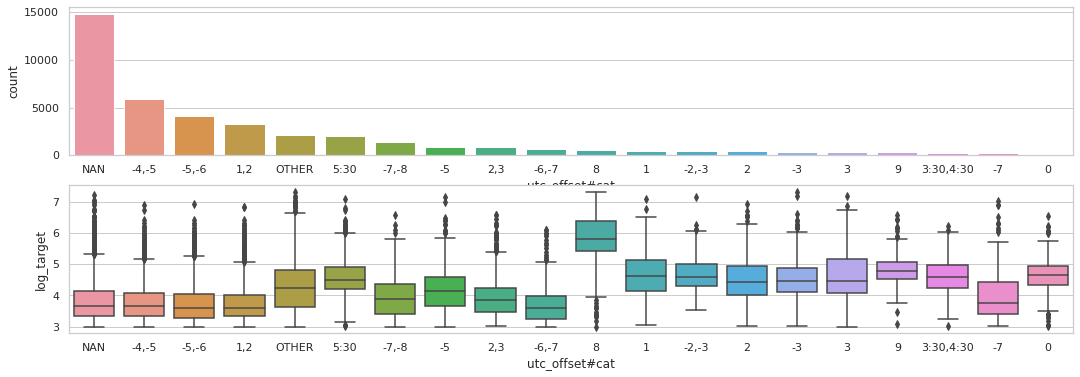

In [334]:
fig, ax = plt.subplots(2, 1, figsize=(18,6))
sns.countplot(data = cat_df, x = 'utc_offset#cat', ax = ax[0], order=utc_offset_count_df.index)
sns.boxplot(data = cat_df, x='utc_offset#cat', y='log_target' , ax = ax[1], order=utc_offset_count_df.index)

# Information value for continuous target: 
 * See https://www.lexjansen.com/sesug/2014/SD-20.pdf
 * The Information value of each category is consistent with its correspondent count and box plot above

![title](img/info_value_continuous_target.png)

In [50]:
def get_IV_continuous_target_df(df, col):
    data = df.copy()
    data['log_target'] = np.log10(df.target)
    data = data.groupby(col).log_target.agg(['count', 'sum']).reset_index()
    data.columns = [col, 'count', 'sum']
    data['sum %'] = (data['sum'] / data['sum'].sum()*100)
    data['count %'] = (data['count'] / data['count'].sum()*100)
    data['IV'] = (data['sum %'] - data['count %']) * np.log(data['sum %'] / data['count %'])
    total_iv = data['IV'].sum()
    return data.sort_values('IV', ascending=False)

In [51]:
get_IV_continuous_target_df(cat_df, 'place_type#cat')

,place_type#cat,count,sum,sum %,count %,IV
0,City,9158,39741.037,25.453,23.109,0.227
6,Village,2960,10280.563,6.585,7.469,0.112
3,NAN,17134,64564.661,41.352,43.235,0.084
5,Town,9345,37421.869,23.968,23.581,0.006
1,Country,1,6.756,0.004,0.003,0.001
4,Region,1017,4060.258,2.601,2.566,0.000
2,Island,15,57.536,0.037,0.038,0.000


In [52]:
iv_df = get_IV_continuous_target_df(cat_df, 'utc_offset#cat')
fraction = int(len(iv_df) / 2)
display_side_by_side(iv_df[:fraction], iv_df[fraction:fraction*2])

,utc_offset#cat,count,sum,sum %,count %,IV
16,8,521,3036.025,1.945,1.315,0.247
15,5:30,1995,9154.327,5.863,5.034,0.126
18,NAN,14842,56227.922,36.013,37.451,0.056
19,OTHER,2001,8638.244,5.533,5.049,0.044
17,9,308,1495.666,0.958,0.777,0.038
0,"-2,-3",447,2092.154,1.340,1.128,0.037
5,"-5,-6",4247,15791.269,10.114,10.717,0.035
9,1,446,2077.053,1.330,1.125,0.034
3,"-4,-5",5893,22116.551,14.165,14.870,0.034
10,"1,2",3310,12351.555,7.911,8.352,0.024


In [53]:
iv_df = get_IV_continuous_target_df(cat_df, 'country#cat')
fraction = int(len(iv_df) / 2)
display_side_by_side(iv_df[:fraction], iv_df[fraction:fraction*2])

,country#cat,count,sum,sum %,count %,IV
17,China,321,1921.518,1.231,0.810,0.176
40,India,1941,8906.854,5.705,4.898,0.123
11,Brazil,748,3522.619,2.256,1.887,0.066
64,OTHER,1203,5404.119,3.461,3.036,0.056
58,NAN,9271,35087.107,22.473,23.394,0.037
4,Australia,2555,9334.871,5.979,6.447,0.035
24,Czech_Republic,880,3050.868,1.954,2.221,0.034
34,Germany,3569,13240.962,8.481,9.006,0.032
45,Japan,279,1343.956,0.861,0.704,0.032
69,Poland,1708,6214.455,3.980,4.310,0.026
